Đang trích xuất đặc trưng HOG cho ảnh: ../flowers/train/lily/5419048_d1f570fdd0_k.jpg


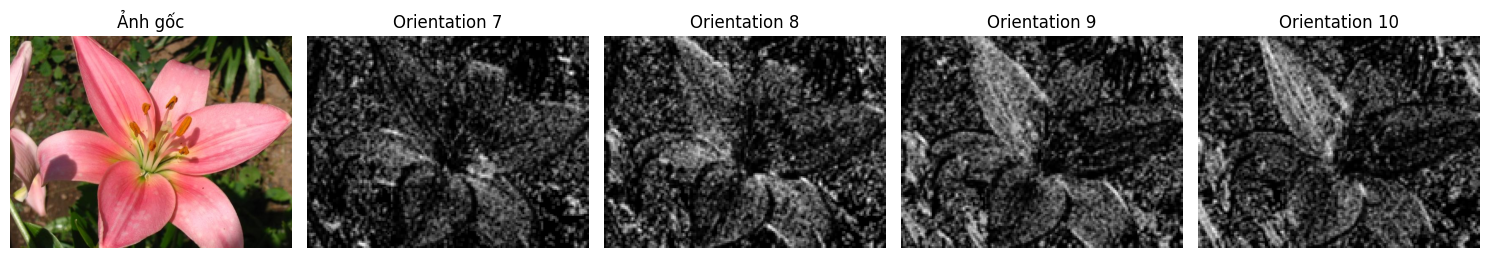

In [1]:
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
import numpy as np

def extract_and_visualize_specific_hog_orientations(image_path):
    """
    Nhập vào một ảnh, trích xuất đặc trưng HOG và hiển thị các kênh định hướng
    được chỉ định (6, 7, 8, 9).

    Args:
        image_path (str): Đường dẫn đến file ảnh.
    """
    # 1. Đọc ảnh
    image = cv2.imread(image_path)
    if image is None:
        print(f"Lỗi: Không thể đọc ảnh từ đường dẫn {image_path}")
        return

    # Chuyển đổi ảnh từ BGR sang RGB để hiển thị với matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 2. Chuyển đổi ảnh sang ảnh xám
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    print(f"Đang trích xuất đặc trưng HOG cho ảnh: {image_path}")

    # 3. Áp dụng HOG để trích xuất đặc trưng
    # Sử dụng 9 orientations, vì 6, 7, 8, 9 (tương ứng index 5, 6, 7, 8) nằm trong phạm vi này.
    num_orientations_to_extract = 11
    fd = hog(gray_image, 
         orientations=num_orientations_to_extract, 
         pixels_per_cell=(4, 4),
         cells_per_block=(2, 2), 
         visualize=False, 
         channel_axis=None, # Hoặc bỏ đi nếu bạn đang dùng scikit-image cũ
         feature_vector=False)
    # Lấy số lượng orientations thực tế từ mảng fd
    num_orientations_actual = fd.shape[-1]
    
    # Tính toán kích thước của ma trận cells
    n_cells_y = fd.shape[0]
    n_cells_x = fd.shape[1]
    
    # Tạo một ma trận để chứa giá trị cường độ cho mỗi orientation tại mỗi cell
    orientation_maps = np.zeros((n_cells_y, n_cells_x, num_orientations_actual))

    # Duyệt qua các blocks và cells để tính trung bình hoặc tổng hợp
    for y in range(n_cells_y):
        for x in range(n_cells_x):
            orientation_maps[y, x, :] = np.mean(fd[y, x], axis=(0, 1))
            
    # Các kênh định hướng muốn hiển thị (index trong mảng, bắt đầu từ 0)
    # Tương ứng với "orientation 6, 7, 8, 9" nếu đếm từ 1
    desired_orientation_indices = [6, 7, 8, 9]  # Chuyển sang index 0-based

    # 4. Hiển thị ảnh gốc và các kênh định hướng được chọn
    plt.figure(figsize=(15, 6)) # Điều chỉnh kích thước figure

    # Ảnh gốc
    plt.subplot(1, 5, 1) # 1 hàng, 5 cột
    plt.imshow(image_rgb)
    plt.title('Ảnh gốc')
    plt.axis('off')

    # Hiển thị từng kênh định hướng được chọn
    for i, orientation_idx in enumerate(desired_orientation_indices):
        if orientation_idx < num_orientations_actual:
            plt.subplot(1, 5, i + 2) # Bắt đầu từ vị trí thứ 2
            
            orientation_channel = orientation_maps[:, :, orientation_idx]
            # Rescale về kích thước ảnh gốc để hiển thị dễ hơn
            orientation_channel_resized = cv2.resize(orientation_channel, (gray_image.shape[1], gray_image.shape[0]), interpolation=cv2.INTER_NEAREST)
            orientation_channel_normalized = exposure.rescale_intensity(orientation_channel_resized, out_range=(0, 1))
            
            plt.imshow(orientation_channel_normalized, cmap='gray')
            plt.title(f'Orientation {orientation_idx + 1}') # Hiển thị theo cách đếm từ 1
            plt.axis('off')
        else:
            print(f"Cảnh báo: Orientation {orientation_idx + 1} không tồn tại (chỉ có {num_orientations_actual} orientations).")
            # Nếu muốn hiển thị một ô trống hoặc thông báo lỗi:
            plt.subplot(1, 5, i + 2)
            plt.text(0.5, 0.5, f'Orientation {orientation_idx + 1}\nKhông tồn tại', 
                     horizontalalignment='center', verticalalignment='center',
                     transform=plt.gca().transAxes, color='red')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
image_path = '../flowers/train/lily/5419048_d1f570fdd0_k.jpg'  # Thay đổi đường dẫn ảnh tại đây
extract_and_visualize_specific_hog_orientations(image_path)

# TRÍCH XUẤT ĐẶC TRƯNG HOG + HSV

In [2]:
import numpy as np
import cv2
import os
from pathlib import Path
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# --- 1. Hàm Trích xuất Color Histogram HSV ---
def extract_color_hist_hsv(img, bins=(8, 8, 8)):
    """Trích HSV color histogram 3D"""
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist(
        [hsv], [0, 1, 2], None,
        bins,
        [0, 180, 0, 256, 0, 256]
    )
    cv2.normalize(hist, hist) 
    return hist.flatten()

# --- 2. Hàm Trích xuất HOG ---
def extract_hog(img, orientations, resize_shape=(128, 128)):
    """Trích HOG feature cho shape/texture"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog_feat = hog(
        gray,
        orientations=orientations, 
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm="L2-Hys",
        transform_sqrt=True,
        feature_vector=True,
        channel_axis=None 
    )
    return hog_feat

# --- 3. Hàm Tổng hợp Đặc trưng (HOG + HSV) ---
def extract_features(img_path, orientations, resize_shape=(128, 128)):
    """Đọc ảnh -> resize -> HOG + HSV color hist -> concat"""
    img = cv2.imread(str(img_path))
    if img is None:
        return None
    
    img = np.ascontiguousarray(img)
    img = cv2.resize(img, resize_shape) 

    hog_feat = extract_hog(img, orientations=orientations, resize_shape=resize_shape)
    color_feat = extract_color_hist_hsv(img, bins=(8, 8, 8))

    features = np.hstack([hog_feat, color_feat])
    return features

# LOAD DATA

In [3]:
# --- 4. Hàm Tải Dữ liệu và Trích xuất Đặc trưng ---
def load_and_extract_features(data_dir, orientations, resize_shape=(128, 128)):
    """Tải đường dẫn ảnh, trích xuất đặc trưng, và mã hóa nhãn."""
    X_features = []
    y_labels = []
    
    data_path = Path(data_dir)
    class_names = sorted([d.name for d in data_path.iterdir() if d.is_dir()])
    
    print(f"Đang tải và trích xuất từ: {data_dir} (Ori={orientations})")

    for class_name in class_names:
        class_path = data_path / class_name
        img_files = list(class_path.glob("*.jpg")) # Tìm file ảnh
        # Thêm các loại file ảnh khác nếu cần...

        for img_path in img_files:
            feats = extract_features(img_path, orientations=orientations, resize_shape=resize_shape)
            
            if feats is not None:
                X_features.append(feats)
                y_labels.append(class_name)

    if not y_labels:
        return np.array([]), np.array([]), class_names

    le = LabelEncoder()
    y_labels_encoded = le.fit_transform(y_labels)

    return np.array(X_features), y_labels_encoded, class_names

# --- CẤU HÌNH VÀ TẢI BAN ĐẦU ---
FLOWER_DATASET_ROOT = '../flowers' 
TRAIN_DIR = os.path.join(FLOWER_DATASET_ROOT, 'train')
VAL_DIR = os.path.join(FLOWER_DATASET_ROOT, 'val')
IMG_SIZE = (128, 128)
DEFAULT_ORIENTATION = 9 

C_list = [10]
gamma_list = ["scale"]
kernel_list = ["rbf"] 
ORIENTATION_VALUES = [7, 8, 9, 10] 

overall_best_model = None
overall_best_val_acc = 0.0
overall_best_orientation = 0
results = []

# Tải dữ liệu ban đầu để kiểm tra
try:
    X_train_base, y_train_base, class_names = load_and_extract_features(TRAIN_DIR, orientations=DEFAULT_ORIENTATION, resize_shape=IMG_SIZE)
    print(f"Kích thước tập huấn luyện gốc: {X_train_base.shape}")
except Exception as e:
    print(f"Lỗi: Không thể tải dữ liệu ban đầu. Vui lòng kiểm tra lại đường dẫn: {FLOWER_DATASET_ROOT}")
    raise e

Đang tải và trích xuất từ: ../flowers\train (Ori=9)
Kích thước tập huấn luyện gốc: (8039, 8612)


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def apply_scaling_and_pca(X_train, X_val, n_components=0.95):
    """Thực hiện Chuẩn hóa và PCA, chỉ Fit trên tập Train."""
    
    # Chuẩn hóa (Standard Scaling)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train) 
    X_val_scaled = scaler.transform(X_val)
    
    # PCA giảm chiều
    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    
    print(f"   [PCA] Kích thước gốc: {X_train_scaled.shape[1]} -> Kích thước sau PCA: {X_train_pca.shape[1]}")
    
    return X_train_pca, X_val_pca

# HUẤN LUYỆN SVM

In [5]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle
# ... (các import khác)

# --- VÒNG LẶP LỒNG NHAU (GRID SEARCH) ---

# Đảm bảo các danh sách tham số C_list, gamma_list, kernel_list đã được định nghĩa
# (Ví dụ: C_list = [0.1, 1, 10, 100], gamma_list = ["scale", "auto", 0.001, 0.01, 0.1], kernel_list = ["rbf", "linear"])

# Reset biến results để lưu trữ metrics chi tiết
results = [] 

for orientation in ORIENTATION_VALUES:
    print("\n==================================================================")
    print(f"🔥 BẮT ĐẦU: Trích xuất đặc trưng với ORIENTATION = {orientation}")
    print("==================================================================")

    # 1. TRÍCH XUẤT ĐẶC TRƯNG MỚI
    try:
        X_train, y_train, _ = load_and_extract_features(TRAIN_DIR, orientation, IMG_SIZE) 
        X_val, y_val, _ = load_and_extract_features(VAL_DIR, orientation, IMG_SIZE)
    except Exception as e:
        print(f"❌ Lỗi tải dữ liệu cho Orientation {orientation}: {e}. Bỏ qua.")
        continue 
    
    # 2. ÁP DỤNG CHUẨN HÓA VÀ PCA
    X_train_for_svm, X_val_for_svm = apply_scaling_and_pca(X_train, X_val)
    
    best_val_acc_for_ori = 0.0
    best_params_for_ori = None
    best_model_for_ori = None

    # 3. GRID SEARCH CHO C và GAMMA
    for C in C_list:
        for gamma in gamma_list:
            for kernel in kernel_list:
                print(f" 	> Đang thử SVM(C={C}, gamma='{gamma}', kernel={kernel}) ...")
                
                clf = SVC(C=C, gamma=gamma, kernel=kernel)
                
                # Huấn luyện trên dữ liệu sau PCA
                clf.fit(X_train_for_svm, y_train) 

                # Đánh giá trên validation
                val_pred = clf.predict(X_val_for_svm) 
                
                # Tính toán các metrics chi tiết (sử dụng average='macro' cho multi-class)
                val_acc = accuracy_score(y_val, val_pred)
                val_precision = precision_score(y_val, val_pred, average='macro', zero_division=0)
                val_recall = recall_score(y_val, val_pred, average='macro', zero_division=0)
                val_f1 = f1_score(y_val, val_pred, average='macro', zero_division=0)
                
                print(f" 	 	--> Val Acc/F1 = {val_acc:.4f} / {val_f1:.4f}")

                current_gamma_used = clf.gamma 

                # Lưu kết quả chi tiết
                results.append({
                    "Orientation": orientation,
                    "Kernel": kernel,
                    "C": C,
                    "Gamma_Setting": gamma,
                    "Gamma_Used": current_gamma_used,
                    "Accuracy": val_acc,
                    "Precision": val_precision,
                    "Recall": val_recall,
                    "F1_Score": val_f1
                })

                # Cập nhật best model cho Orientation hiện tại
                if val_acc > best_val_acc_for_ori:
                    best_val_acc_for_ori = val_acc
                    best_model_for_ori = clf
                    best_params_for_ori = {"C": C, "gamma": gamma, "kernel": kernel}

    # 4. CẬP NHẬT KẾT QUẢ TỔNG THỂ VÀ IN RA
    print(f"\n--- KẾT QUẢ TỐT NHẤT TRONG ORIENTATION {orientation} ---")
    print(f"✅ C đã dùng: {best_model_for_ori.C}")
    print(f"✅ Gamma đã dùng (giá trị thực): {best_model_for_ori.gamma}")
    
    if best_val_acc_for_ori > overall_best_val_acc:
        overall_best_val_acc = best_val_acc_for_ori
        overall_best_model = best_model_for_ori
        overall_best_params = best_params_for_ori
        overall_best_orientation = orientation


print("\n\n#####################################################")
print("🚀 KẾT QUẢ TỐT NHẤT TỔNG THỂ")
print("#####################################################")
print(f"Best Orientation: {overall_best_orientation}")
print(f"Best val accuracy: {overall_best_val_acc:.4f}")
if overall_best_model:
    print(f"Best C đã dùng: {overall_best_model.C}")
    print(f"Best Gamma đã dùng (giá trị thực): {overall_best_model.gamma}")

# ---------------------------------------------------------------------
# 🛑 LƯU MÔ HÌNH TỐT NHẤT 💾
# ---------------------------------------------------------------------

if overall_best_model:
    BEST_MODEL_FILENAME = 'best_svm_pca_hog_classifier.pkl'
    try:
        with open(BEST_MODEL_FILENAME, 'wb') as file:
            pickle.dump(overall_best_model, file)
        print(f"\n✅ Đã lưu mô hình SVM tốt nhất vào file: {BEST_MODEL_FILENAME}")
    except Exception as e:
        print(f"\n❌ Lỗi khi lưu mô hình: {e}")

# ---------------------------------------------------------------------
# 📊 TẠO VÀ IN BẢNG TỔNG KẾT METRICS 📊
# ---------------------------------------------------------------------
print("\n\n#####################################################")
print("📊 BẢNG TỔNG KẾT METRICS GRID SEARCH")
print("#####################################################")

if results:
    df_results = pd.DataFrame(results)
    
    # 1. 🛑 SỬA LỖI: Ép kiểu Gamma_Used về số (float)
    # Sử dụng errors='coerce' để biến chuỗi không phải số (như 'scale') thành NaN
    # Trong trường hợp này, Gamma_Used sẽ KHÔNG chứa 'scale' hay 'auto' nếu logic đúng, 
    # nhưng đây là lớp bảo vệ tốt nhất.
    df_results['Gamma_Used'] = pd.to_numeric(df_results['Gamma_Used'], errors='coerce') 

    # 2. Định dạng lại các cột số để dễ đọc
    df_results['Accuracy'] = df_results['Accuracy'].map('{:.4f}'.format)
    df_results['Precision'] = df_results['Precision'].map('{:.4f}'.format)
    df_results['Recall'] = df_results['Recall'].map('{:.4f}'.format)
    df_results['F1_Score'] = df_results['F1_Score'].map('{:.4f}'.format)
    
    # 3. Định dạng Gamma_Used (Chỉ áp dụng sau khi chắc chắn nó là số)
    df_results['Gamma_Used'] = df_results['Gamma_Used'].map('{:.6f}'.format)
    # Chọn và hiển thị các cột quan trọng
    display_cols = ["Orientation", "Kernel", "C", "Gamma_Setting", "Accuracy", "F1_Score", "Precision", "Recall"]
    
    # Sắp xếp theo Accuracy (để thấy kết quả tốt nhất)
    df_results['Accuracy_Sort'] = pd.to_numeric(df_results['Accuracy'])
    df_results = df_results.sort_values(by='Accuracy_Sort', ascending=False).drop(columns='Accuracy_Sort')
    
    print(df_results[display_cols].to_markdown(index=False))
else:
    print("Không có kết quả nào được ghi nhận.")


🔥 BẮT ĐẦU: Trích xuất đặc trưng với ORIENTATION = 7
Đang tải và trích xuất từ: ../flowers\train (Ori=7)
Đang tải và trích xuất từ: ../flowers\val (Ori=7)
   [PCA] Kích thước gốc: 6812 -> Kích thước sau PCA: 1727
 	> Đang thử SVM(C=10, gamma='scale', kernel=rbf) ...
 	 	--> Val Acc/F1 = 0.8097 / 0.8104

--- KẾT QUẢ TỐT NHẤT TRONG ORIENTATION 7 ---
✅ C đã dùng: 10
✅ Gamma đã dùng (giá trị thực): scale

🔥 BẮT ĐẦU: Trích xuất đặc trưng với ORIENTATION = 8
Đang tải và trích xuất từ: ../flowers\train (Ori=8)
Đang tải và trích xuất từ: ../flowers\val (Ori=8)
   [PCA] Kích thước gốc: 7712 -> Kích thước sau PCA: 1891
 	> Đang thử SVM(C=10, gamma='scale', kernel=rbf) ...
 	 	--> Val Acc/F1 = 0.8019 / 0.8026

--- KẾT QUẢ TỐT NHẤT TRONG ORIENTATION 8 ---
✅ C đã dùng: 10
✅ Gamma đã dùng (giá trị thực): scale

🔥 BẮT ĐẦU: Trích xuất đặc trưng với ORIENTATION = 9
Đang tải và trích xuất từ: ../flowers\train (Ori=9)
Đang tải và trích xuất từ: ../flowers\val (Ori=9)
   [PCA] Kích thước gốc: 8612 -> Kích

ImportError: Missing optional dependency 'tabulate'.  Use pip or conda to install tabulate.